In [8]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
import matplotlib.colors as colors
import cartopy.feature as cfea

#https://iridl.ldeo.columbia.edu/SOURCES/.CIESIN/.GPWv3/.grid2p5arcmin/.madmg/index.html?Set-Language=en

In [5]:
path = '/mnt/c/Users/tsimk/Downloads/research/H08/additional_data/GPWv4/administrative_unit/gpw-v3-grid2p5arcmin-madmg-Datafiles.nc'
nc_data = nc.Dataset(path)
var_name = 'madmg'
adm = nc_data.variables[var_name][:]
print(nc_data.variables[var_name].long_name)
print(nc_data.variables[var_name].units)

Mean Geographic Unit Area
km2


In [6]:
print(adm.shape)

(3432, 8640)


In [15]:
# 内挿の実験

# 元データの緯度範囲と分解能
original_lat_start = 84.97916
original_lat_end = -57.97917
resolution = 0.04166666
original_shape = (3432, 8640)

# 全球緯度範囲
global_lat_start = 90.0
global_lat_end = -90.0
global_shape = (4320, 8640)  # 全球格子の形状

# 元データの読み込み (ダミーデータとしてランダム値を使用)
original_data = np.random.rand(*original_shape)

# 全球グリッドを初期化 (-9999で埋める)
global_data = np.full(global_shape, -9999, dtype=adm.dtype)

# 全球緯度リストを作成
global_latitudes = np.linspace(global_lat_start, global_lat_end, global_shape[0])

# 元データの緯度範囲に対応するインデックスを計算
start_index = np.argmin(np.abs(global_latitudes - original_lat_start))
end_index = start_index + original_shape[0]

# 元データを挿入
if end_index <= global_data.shape[0]:
    global_data[start_index:end_index, :] = adm
else:
    raise ValueError("Calculated indices exceed global grid size.")

# 結果の確認
print(f"Global Data Shape: {global_data.shape}")
print(f"Start Index: {start_index}, End Index: {end_index}")
print(f"Data Padding at Top: {start_index} rows")
print(f"Data Padding at Bottom: {global_shape[0] - end_index} rows")
print(f"Sample Top Rows (Padding):")
print(global_data[:start_index, :10])  # パディング部分
print(f"Sample Data (Middle):")
print(global_data[start_index:start_index + 10, :10])  # 挿入されたデータ部分

Global Data Shape: (4320, 8640)
Start Index: 120, End Index: 3552
Data Padding at Top: 120 rows
Data Padding at Bottom: 768 rows
Sample Top Rows (Padding):
[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
Sample Data (Middle):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


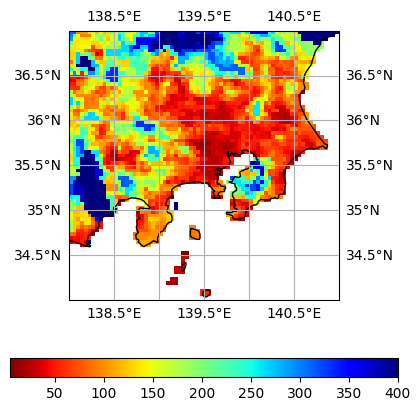

In [50]:

def geography():
    SUF = '.gl2'
    dtype = 'float32'
    #
    a = 4320
    b = 8640
    gl2shape = (a, b)
    #
    city_num = 1
    #
    # region
    one = 138
    two = 141
    three = 34
    four = 37
    #
    resolution = 24
    upperindex = (90-four)*resolution
    lowerindex = (90-three)*resolution
    leftindex = (180+one)*resolution
    rightindex = (180+two)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)
    
    return a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num
    
a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()
adm_cropped = global_data[upperindex:lowerindex, leftindex:rightindex]
adm_cropped = np.ma.masked_where(adm_cropped<=0, adm_cropped)

fig = plt.figure(figsize=(5,5))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(img_extent)
ax.gridlines(draw_labels=True)

from matplotlib.colors import ListedColormap, BoundaryNorm
im = ax.imshow(adm_cropped, origin='upper',extent=img_extent, transform=projection, cmap='jet_r',
               vmax=400)
# カラーバーを作成
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')  # ラベル位置調整
# unit = km

In [45]:
def upscale(i0x1max, i0y1max, i0x2max, i0y2max, r2vhr):
    """
    Upscale r2vhr to r2out based on the option (max).
    """
    # upscale r2vhr to r2out
    # missing value
    r2out = np.empty((i0y1max, i0x1max))
    p0mis = -9999
    
    # Loop through the output grid
    for i0y1 in range(i0y1max):
        for i0x1 in range(i0x1max):
            r0max = -np.inf  # Initialize max value
            i0cnt = 0
            
            # 2x2 summation loop
            for i0y2 in range(i0y2max):
                for i0x2 in range(i0x2max):
                    # x location of r2vhr 
                    i0x = (i0x1) * i0x2max + i0x2
                    # y location of r2vhr
                    i0y = (i0y1) * i0y2max + i0y2
                    r0dat = r2vhr[i0y, i0x]
                    
                    # Update max value if valid data
                    if r0dat != p0mis:
                        r0max = max(r0max, r0dat)
                        i0cnt += 1
            
            # Save the maximum value or missing value
            if i0cnt > 0:
                r2out[i0y1, i0x1] = r0max
            else:
                r2out[i0y1, i0x1] = p0mis
        
        if i0y1 % 100 == 0:
            print(f"i0y1: {i0y1}")
    
    return r2out

In [46]:
r2gl5 = upscale(4320, 2160, 2, 2, global_data)

i0y1: 0
i0y1: 100
i0y1: 200
i0y1: 300
i0y1: 400
i0y1: 500
i0y1: 600
i0y1: 700
i0y1: 800
i0y1: 900
i0y1: 1000
i0y1: 1100
i0y1: 1200
i0y1: 1300
i0y1: 1400
i0y1: 1500
i0y1: 1600
i0y1: 1700
i0y1: 1800
i0y1: 1900
i0y1: 2000
i0y1: 2100


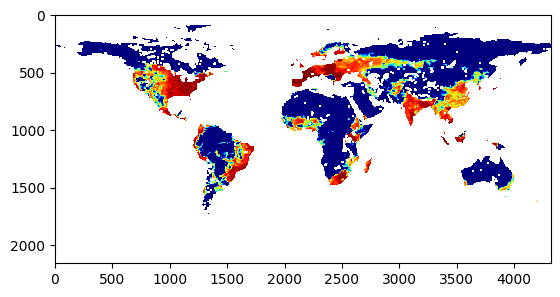

643157.625
0.02010926976799965
643157.625
0.02010926976799965


In [58]:
r2gl5_masked = np.ma.masked_where(r2gl5 <= 0, r2gl5)
plt.imshow(r2gl5_masked, cmap='jet_r', vmax=10000)
plt.show()
print(np.max(r2gl5_masked))
print(np.min(r2gl5_masked))
print(np.max(r2gl5_masked))
print(np.min(r2gl5_masked))

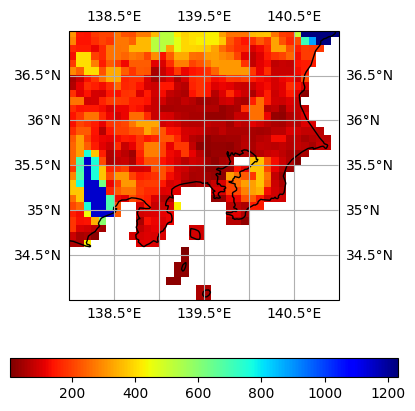

In [56]:
def geography():
    SUF = '.gl5'
    dtype = 'float32'
    #
    a = 2160
    b = 4320
    gl2shape = (a, b)
    #
    city_num = 1
    #
    # region
    one = 138
    two = 141
    three = 34
    four = 37
    #
    resolution = 12
    upperindex = (90-four)*resolution
    lowerindex = (90-three)*resolution
    leftindex = (180+one)*resolution
    rightindex = (180+two)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)
    
    return a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num

a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()
gl5_cropped = r2gl5_masked[upperindex:lowerindex, leftindex:rightindex]

fig = plt.figure(figsize=(5,5))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(img_extent)
ax.gridlines(draw_labels=True)
im = ax.imshow(gl5_cropped, origin='upper',extent=img_extent, transform=projection, cmap='jet_r')
cbar = fig.colorbar(im, orientation='horizontal')

In [59]:
# wrte_binary
save_flag = False
if save_flag is True:
    r2gl5_filled = r2gl5_masked.filled(-9999)
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/adm_ara_'
    savepath_gl5 = f"{h08dir}/GPW3_agua____2000.gl5" 
    r2gl5_filled.astype(np.float32).tofile(savepath_gl5)

(1740, 4320)
643157.6


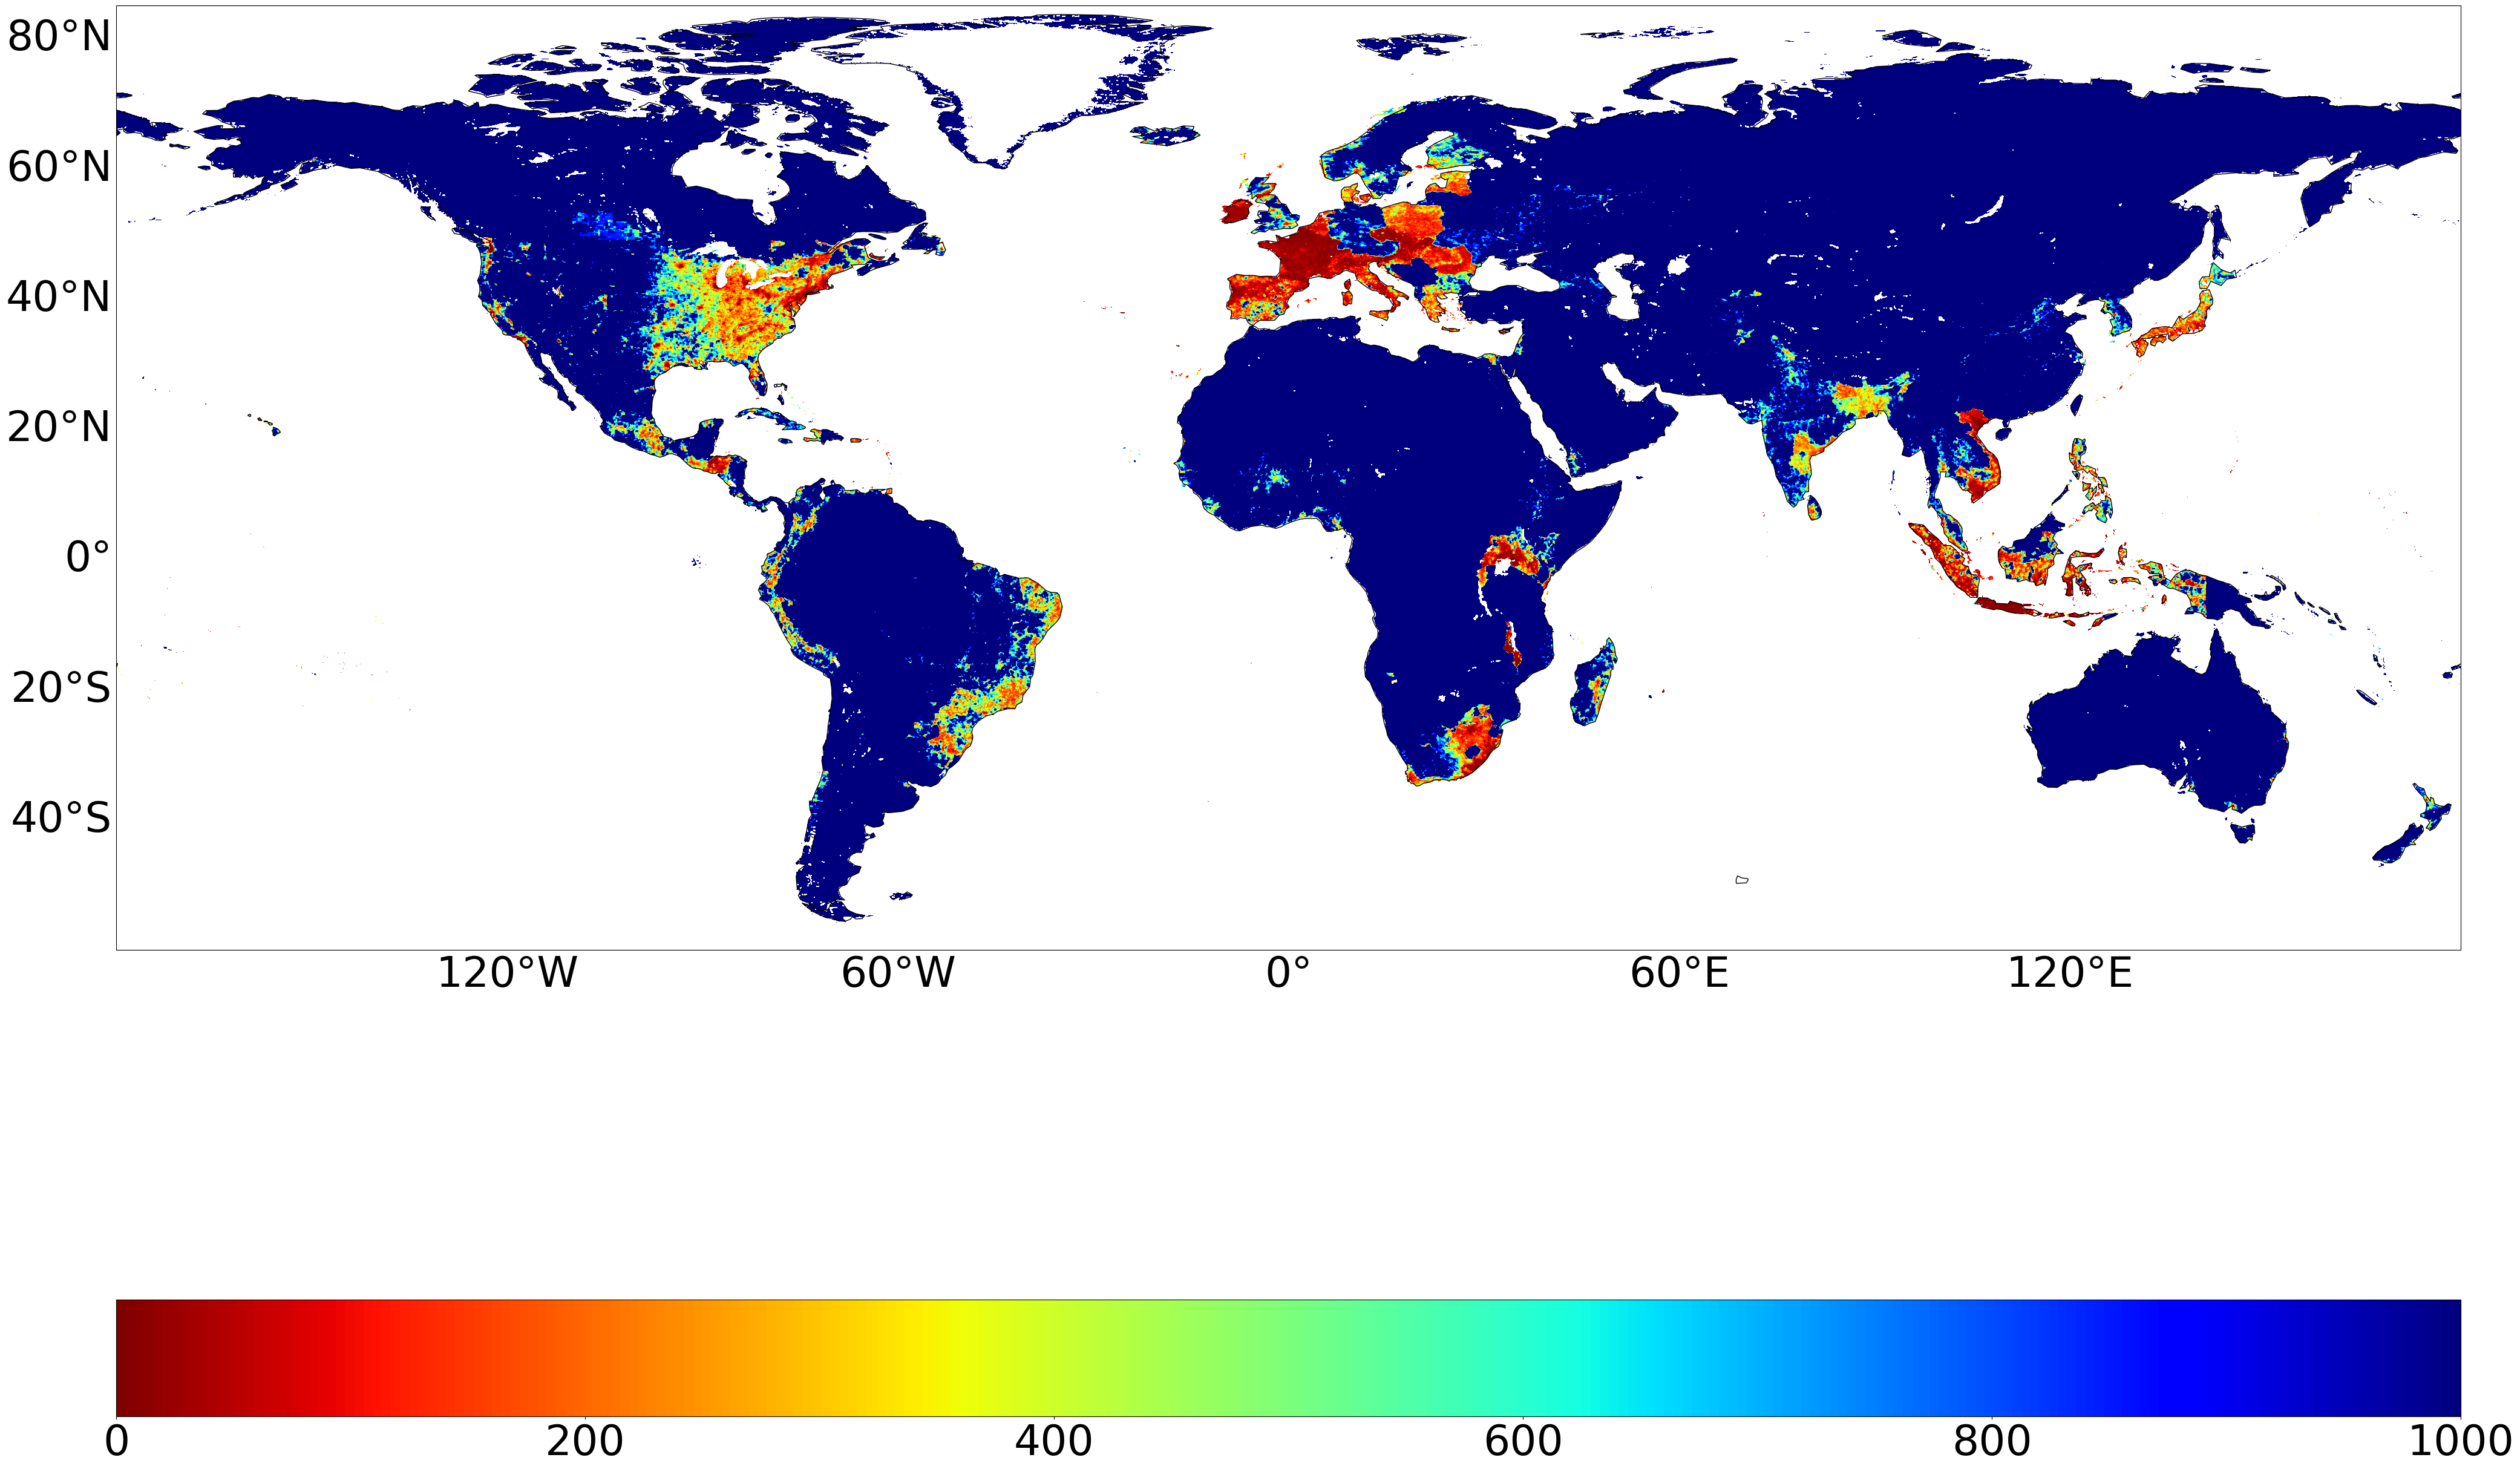

In [85]:
import matplotlib.ticker as mticker
# read_binary
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/adm_ara_'
loadpath = f"{h08dir}/GPW3_agua____2000.gl5" 
tmp = np.fromfile(loadpath, dtype='float32').reshape(2160, 4320)
tmp_masked = np.ma.masked_where(tmp<0, tmp)
def geography():
    SUF = '.gl5'
    dtype = 'float32'
    #
    a = 2160
    b = 4320
    #
    # region
    one = -180
    two = 180
    three = -60
    four = 85
    #
    resolution = 12
    upperindex = (90-four)*resolution
    lowerindex = (90-three)*resolution
    leftindex = (180+one)*resolution
    rightindex = (180+two)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)
    
    return a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num

a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()
tmp_cropped = tmp_masked[upperindex:lowerindex, leftindex:rightindex]
print(tmp_cropped.shape)

fig = plt.figure(figsize=(50,50))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(img_extent)
gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
#gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 10))
#gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 10))
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 50, 'color': 'black'}
gl.ylabel_style = {'size': 50, 'color': 'black'}
ax.gridlines(visible=False)
ax.spines['geo'].set_visible(True)
im = ax.imshow(tmp_cropped, origin='upper',extent=img_extent, transform=projection, cmap='jet_r',
              vmin = 0, vmax=1000)
cbar = fig.colorbar(im, orientation='horizontal', )
cbar.ax.tick_params(labelsize=50) 
print(np.max(tmp_cropped))

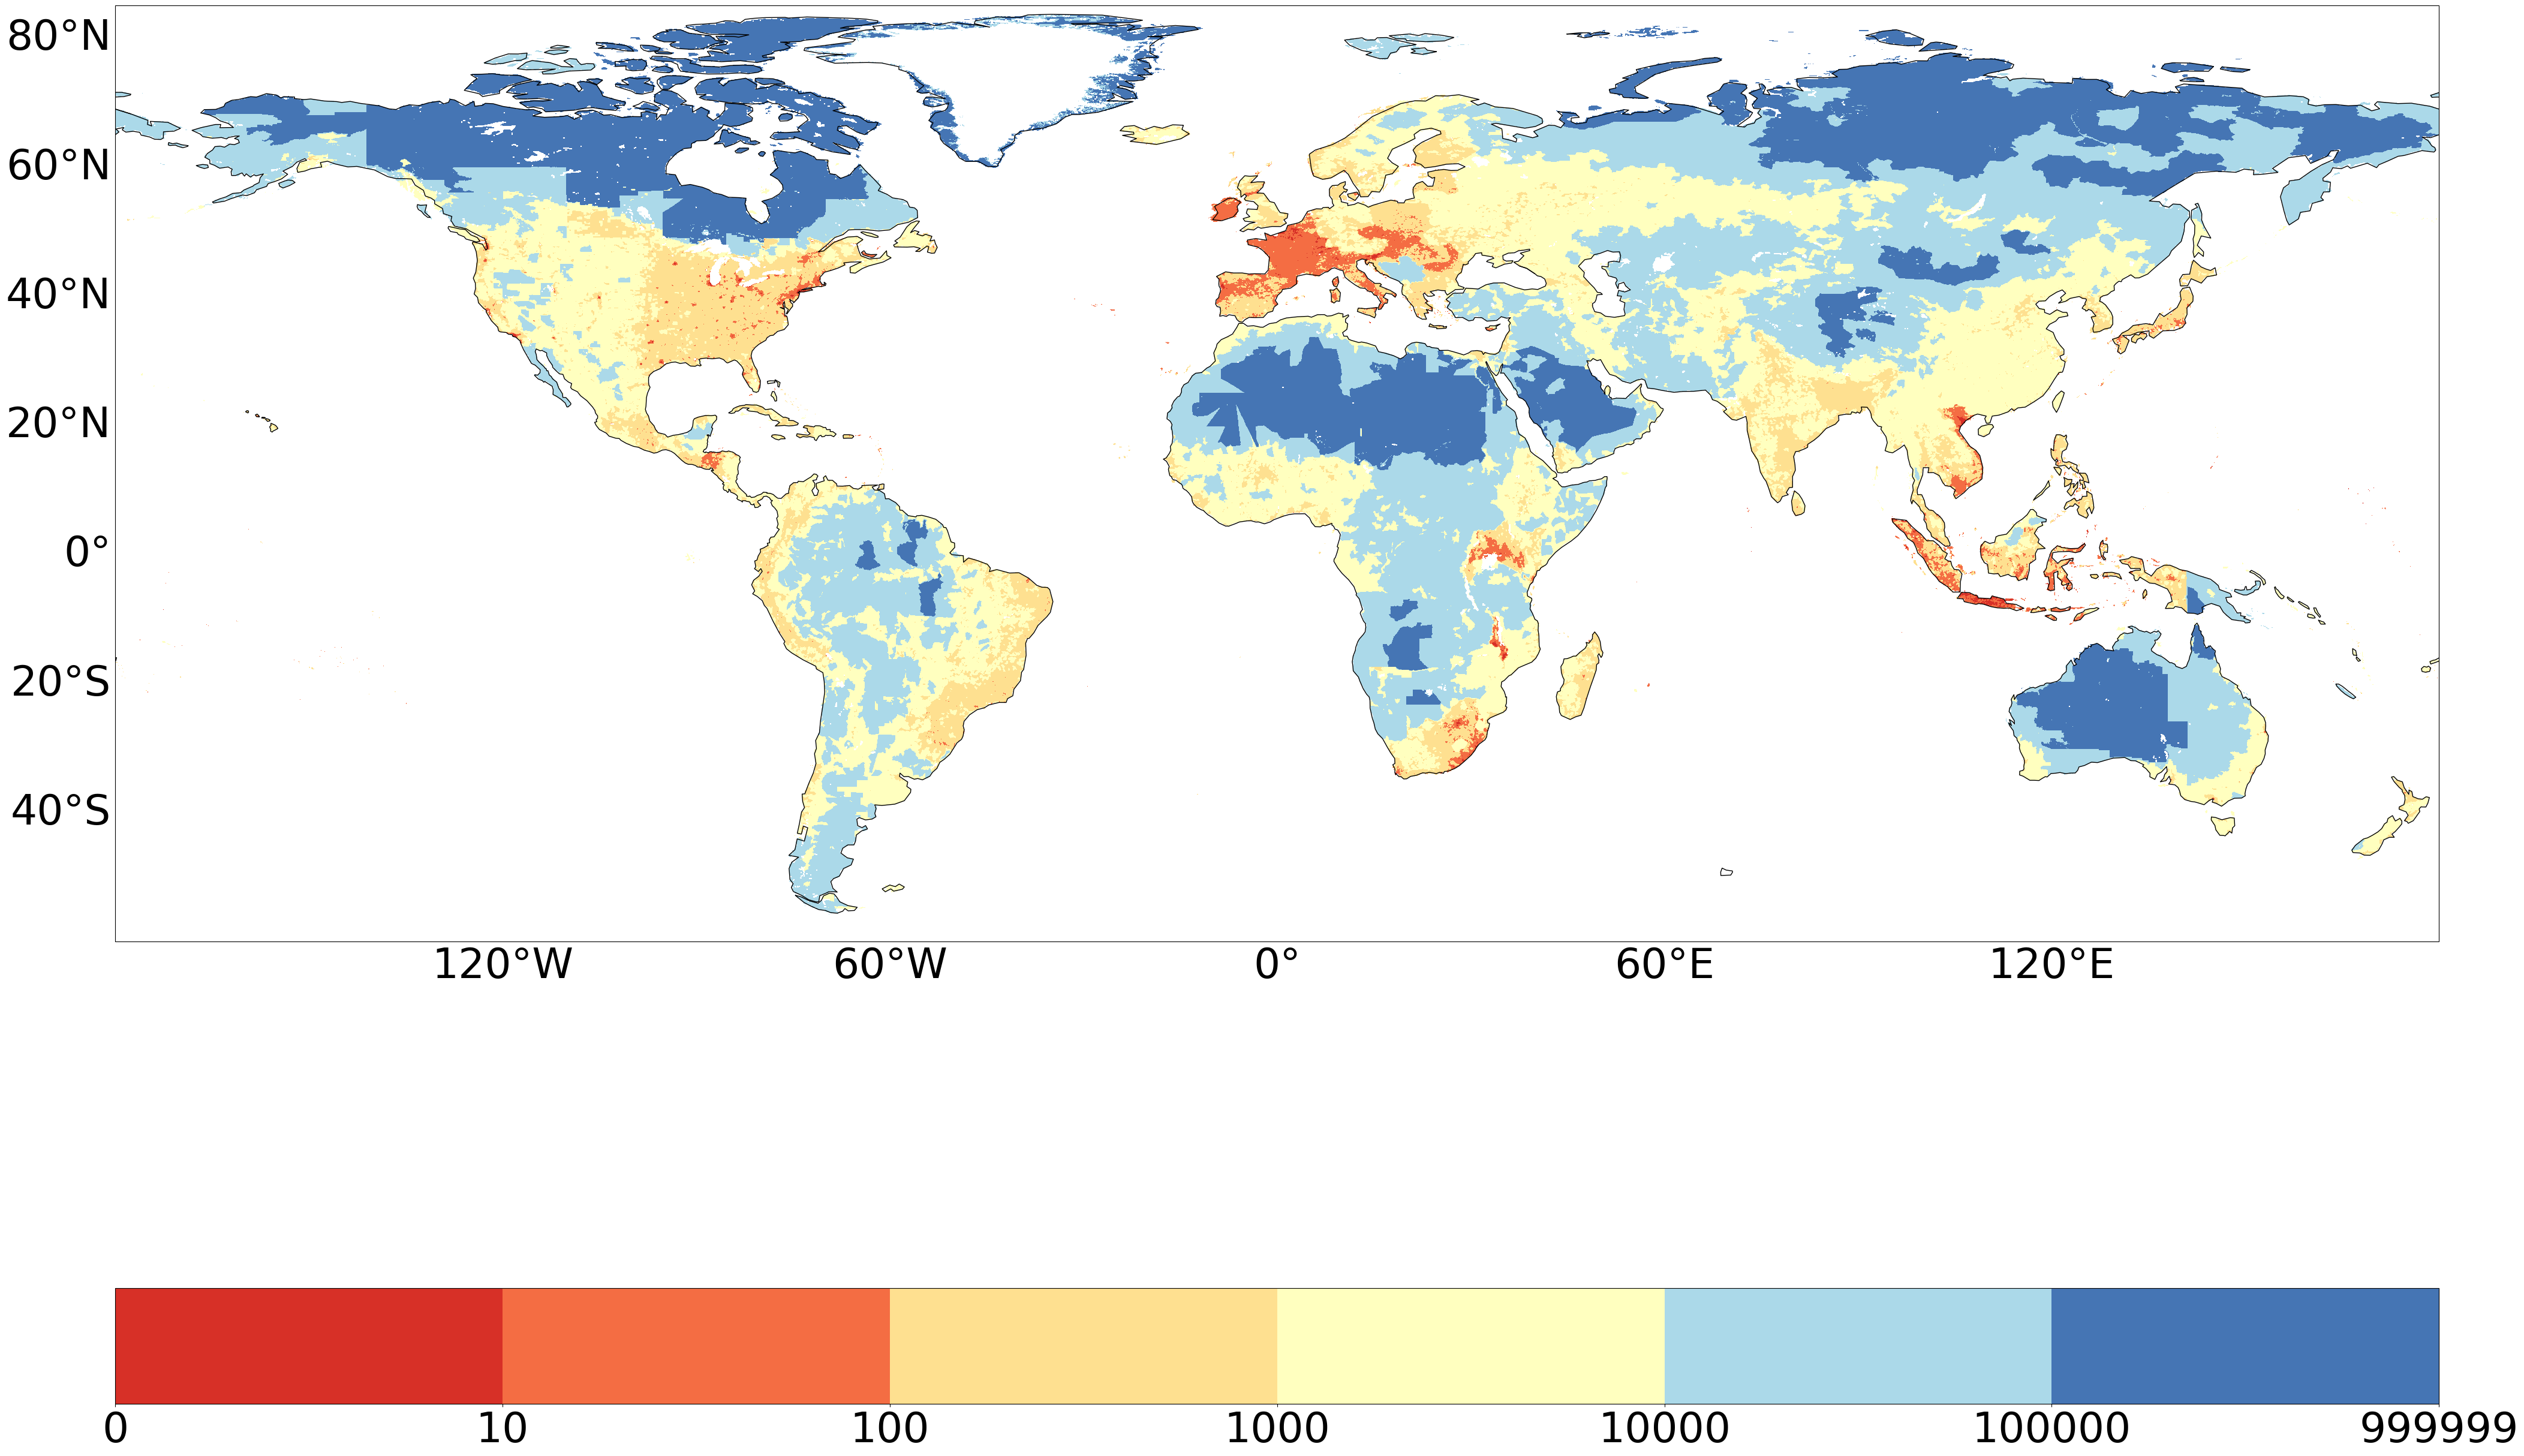

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# 閾値と色を定義
boundaries = [0, 10, 100, 1000, 10000,  100000, 1000000-1]  # 閾値
colors = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4']  # 色リスト

# カラーマップと正規化オブジェクトを作成
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N)

# プロット
fig = plt.figure(figsize=(50,50))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(img_extent)
gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
#gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 10))
#gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 10))
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 50, 'color': 'black'}
gl.ylabel_style = {'size': 50, 'color': 'black'}
ax.gridlines(visible=False)
ax.spines['geo'].set_visible(True)
im = ax.imshow(tmp_cropped, origin='upper',extent=img_extent, transform=projection, cmap=cmap, norm=norm)

# カラーバーを追加
cbar = fig.colorbar(im, ticks=boundaries, orientation='horizontal')
cbar.ax.tick_params(labelsize=50)  # カラーバーのラベルサイズを調整

plt.show()

In [166]:
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat'
loadpath = f"{h08dir}/adm_ara_/GPW3_agua____2000.gl5" 
admara = np.fromfile(loadpath, dtype='float32').reshape(2160, 4320)
admara_masked = np.ma.masked_where(admara<0, admara)

maskpath = f"{h08dir}/cty_msk_/city_clrd0000.gl5" 
ctymsk = np.fromfile(maskpath, dtype='float32').reshape(2160, 4320)

ara_list = []
for city_id in range(1, 1861):
    coord = np.where(ctymsk==city_id)
    cand = admara_masked[coord]
    if city_id%100 == 0:
        print(city_id)
    if cand.size > 0:
        cand_mean = np.mean(cand)
        ara_list.append(cand_mean)
    else:
        continue

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [167]:
he_text = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/he_validation.txt'
cama_text = f'/mnt/c/users/tsimk/downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_second.txt'
cama_new_text = f'/mnt/c/users/tsimk/downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_third.txt'

with open(he_text, 'r') as files:
    he_lines = files.readlines()
with open(cama_text, 'r') as files:
    cama_lines = files.readlines()
with open(cama_new_text, 'r') as files:
    new_lines = files.readlines()
    
true_list = []
false_list = []
rate_list = []
region_list = []
pop_list = []

for ind in range(1860):
    # cama file
    line_new = new_lines[ind]
    parts_new = line_new.split('|')
    parts_new = [item.strip() for item in parts_new]
    ovlp_flg = parts_new[1]
    dwn_flg = parts_new[2]
    region = parts_new[12]
    if ovlp_flg == 'RMVD' or dwn_flg == 'NoMK':
        continue
    pop_list.append(float(parts_new[3])*10**3)

    # he file
    for line in he_lines:
        if int(line.split('|')[0].strip()) == int(ind)+1:
            line_he = line
    parts_he = line_he.split('|')
    parts_he = [item.strip() for item in parts_he]
    true_list.append(int(parts_he[2]))
    false_list.append(int(parts_he[3]))
    rate_list.append(int(parts_he[2])/(int(parts_he[2])+int(parts_he[3])))
    region_list.append(region)

In [168]:
print(len(rate_list))
print(len(ara_list))

1604
1604


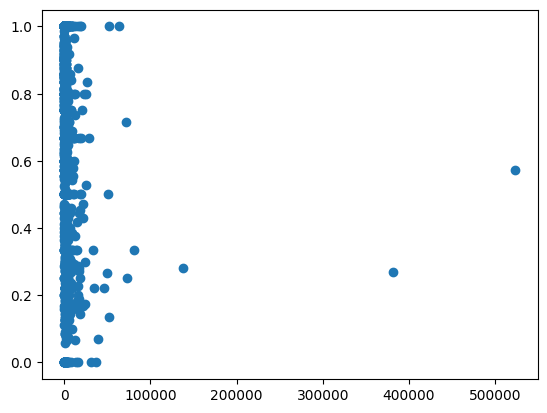

In [169]:
plt.scatter(ara_list, rate_list)

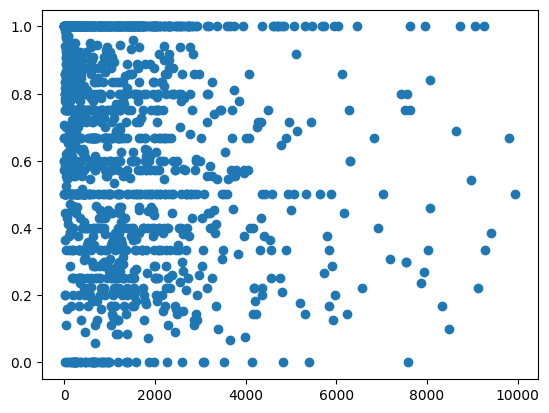

In [170]:
# 閾値
threshold = 10000

# 閾値に基づいてフィルタリング
filtered_indices = np.array(ara_list) <= threshold
filtered_ara_list = np.array(ara_list)[filtered_indices]
filtered_rate_list = np.array(rate_list)[filtered_indices]
plt.scatter(filtered_ara_list, filtered_rate_list)

回帰直線の式: y = -0.37x + 0.72


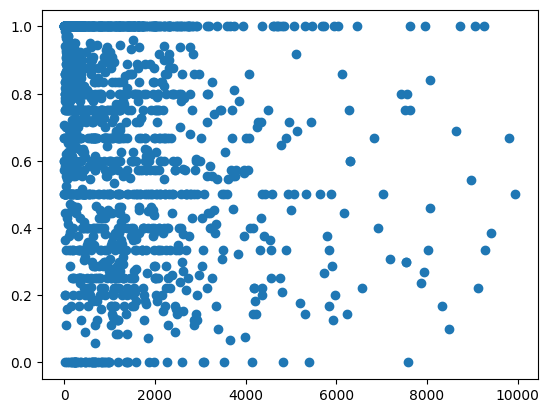

In [175]:
# 閾値に基づいてフィルタリング
sample_num = 1600
selected_ara_list = ara_list[:sample_num]
selected_rate_list = rate_list[:sample_num]
# 閾値
threshold = 10000

# 閾値に基づいてフィルタリング
filtered_indices = np.array(selected_ara_list) <= threshold
filtered_ara_list = np.array(selected_ara_list)[filtered_indices]
filtered_rate_list = np.array(selected_rate_list)[filtered_indices]
plt.scatter(filtered_ara_list, filtered_rate_list)

slope, intercept = np.polyfit(filtered_ara_list, filtered_rate_list, 1)
# 回帰直線の方程式
print(f"回帰直線の式: y = {slope*1e4:.2f}x + {intercept:.2f}")


In [127]:
for i in range(10, 20):
    print(filtered_ara_list[i], filtered_rate_list[i])

252.12885485197367 0.6842105263157895
371.24482783564815 0.8703703703703703
131.08897047776443 1.0
3377.4907670454545 0.5454545454545454
4894.974571078431 0.6666666666666666
732.3270399305555 0.9444444444444444
4.841081237792968 1.0
145.88114013671876 0.9
835.4556842672414 1.0
5455.05078125 1.0
